In [1]:
!python --version

Python 3.12.4


In [2]:
!nvidia-smi

Tue Oct  8 17:18:50 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.90                 Driver Version: 565.90         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1660 Ti   WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   64C    P0             26W /   80W |     577MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
# !pip install supervision
# !pip install timm
# !python -m pip install --upgrade pip
# !pip install supervision
# !pip install timm
# !pip install cython
# !pip install pycocotools
# !pip install scipy

# !pip install transformers
# !pip install pytorch-lightning
# !pip install tensorboard

### 1. Create COCO data loader


In [4]:
import torchvision
import os

ANNOTATION_FILE_NAME = "annotations.json"

class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, processor, train=True):
        ann_file = os.path.join(img_folder, ANNOTATION_FILE_NAME)
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.processor = processor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        # feel free to add data augmentation here before passing them to the next step
        img, target = super(CocoDetection, self).__getitem__(idx)

        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.processor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"][0] # remove batch dimension

        return pixel_values, target

In [5]:
from transformers import DetrImageProcessor

processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

dataset = '../Manga109/dataset_split'
TRAIN_DIRECTORY = os.path.join(dataset, "train")
VAL_DIRECTORY = os.path.join(dataset, "val")
TEST_DIRECTORY = os.path.join(dataset, "test")

train_dataset = CocoDetection(img_folder=TRAIN_DIRECTORY, processor=processor)
val_dataset = CocoDetection(img_folder=VAL_DIRECTORY, processor=processor, train=False)

loading annotations into memory...
Done (t=0.84s)
creating index...
index created!
loading annotations into memory...
Done (t=0.18s)
creating index...
index created!


In [6]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))

Number of training examples: 6880
Number of validation examples: 1343


Image n°4241
annotations: 52


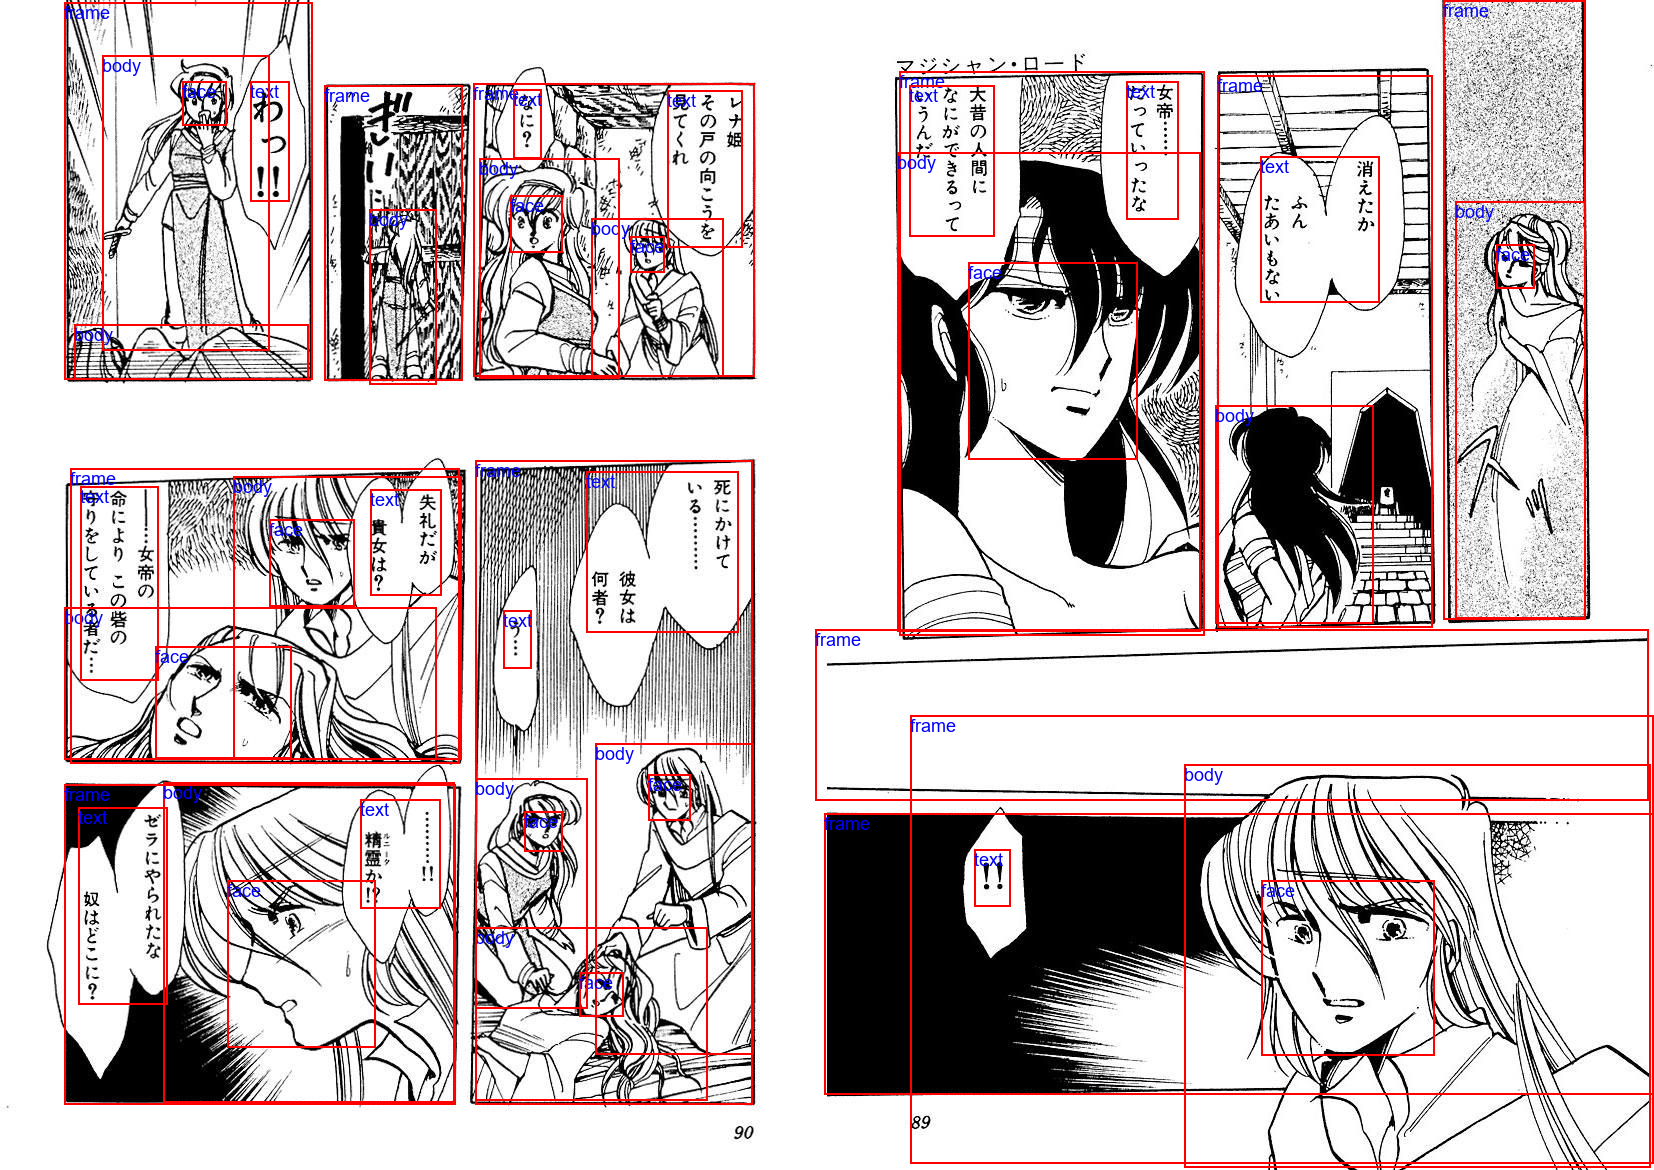

In [7]:
import numpy as np
import os
from PIL import Image, ImageDraw, ImageFont

# based on https://github.com/woctezuma/finetune-detr/blob/master/finetune_detr.ipynb
image_ids = train_dataset.coco.getImgIds()

# let's pick a random image
image_id = image_ids[np.random.randint(0, len(image_ids))]
# image_id = image_ids[17]
# print(f'image_id: {image_id}')

print('Image n°{}'.format(image_id))
image = train_dataset.coco.loadImgs(image_id)[0]
# print(f'image: {image}')

image = Image.open(os.path.join(TRAIN_DIRECTORY, image['file_name']))

annotations = train_dataset.coco.imgToAnns[image_id]
# print(f'annotations: {annotations}')
print(f'annotations: {len(annotations)}')

font = ImageFont.truetype("arial.ttf", size=18)
draw = ImageDraw.Draw(image, "RGBA")

cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

for annotation in annotations:
    box = annotation['bbox']
    class_idx = annotation['category_id']
    x,y,w,h = tuple(box)
    draw.rectangle((x,y,x+w,y+h), outline='red', width=2)
    draw.text((x, y), id2label[class_idx], fill='blue', font=font)

image

In [8]:
from torch.utils.data import DataLoader

def collate_fn(batch):
  pixel_values = [item[0] for item in batch]
  encoding = processor.pad(pixel_values, return_tensors="pt")
  labels = [item[1] for item in batch]
  batch = {}
  batch['pixel_values'] = encoding['pixel_values']
  batch['pixel_mask'] = encoding['pixel_mask']
  batch['labels'] = labels
  return batch

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=2)
batch = next(iter(train_dataloader))

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [9]:
batch.keys()

dict_keys(['pixel_values', 'pixel_mask', 'labels'])

In [10]:
pixel_values, target = train_dataset[0]

In [11]:
pixel_values.shape

torch.Size([3, 800, 1130])

In [12]:
print(target)

{'size': tensor([ 800, 1130]), 'image_id': tensor([0]), 'class_labels': tensor([], dtype=torch.int64), 'boxes': tensor([], size=(0, 4)), 'area': tensor([]), 'iscrowd': tensor([], dtype=torch.int64), 'orig_size': tensor([1170, 1654])}


## 2. Train the model using PyTorch Lightning

In [13]:
import pytorch_lightning as pl
from transformers import DetrForObjectDetection
import torch

class Detr(pl.LightningModule):
     def __init__(self, lr, lr_backbone, weight_decay):
         super().__init__()
         # replace COCO classification head with custom head
         # we specify the "no_timm" variant here to not rely on the timm library
         # for the convolutional backbone
         self.model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50",
                                                             revision="no_timm",
                                                             num_labels=len(id2label),
                                                             ignore_mismatched_sizes=True)
         # see https://github.com/PyTorchLightning/pytorch-lightning/pull/1896
         self.lr = lr
         self.lr_backbone = lr_backbone
         self.weight_decay = weight_decay

     def forward(self, pixel_values, pixel_mask):
       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

       return outputs

     def common_step(self, batch, batch_idx):
       pixel_values = batch["pixel_values"]
       pixel_mask = batch["pixel_mask"]
       labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

       loss = outputs.loss
       loss_dict = outputs.loss_dict

       return loss, loss_dict

     def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
          self.log("train_" + k, v.item())

        return loss

     def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("validation_loss", loss)
        for k,v in loss_dict.items():
          self.log("validation_" + k, v.item())

        return loss

     def configure_optimizers(self):
        param_dicts = [
              {"params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
              {
                  "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                  "lr": self.lr_backbone,
              },
        ]
        optimizer = torch.optim.AdamW(param_dicts, lr=self.lr,
                                  weight_decay=self.weight_decay)

        return optimizer

     def train_dataloader(self):
        return train_dataloader

     def val_dataloader(self):
        return val_dataloader

In [14]:
# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

Reusing TensorBoard on port 6006 (pid 1732), started 0:26:06 ago. (Use '!kill 1732' to kill it.)

In [15]:
model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)

outputs = model(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([5, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
outputs.logits.shape

torch.Size([4, 100, 5])

#### Start training:

In [17]:
import torch
print(torch.cuda.is_available())  

True


In [ ]:
from pytorch_lightning import Trainer

# trainer = Trainer(accelerator='gpu', max_steps=300, gradient_clip_val=0.1)
trainer = Trainer(
    accelerator='gpu',
    max_epochs=20,            
    limit_train_batches=1.0,    
    limit_val_batches=1.0,      
    gradient_clip_val=0.1,     
    logger=None,          
    callbacks=None,     
    enable_checkpointing=True    
)
trainer.fit(model)